In [3]:
%matplotlib notebook
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os,glob
import math

from osgeo import gdal, osr

import subprocess
import json

import matplotlib.patches as mpatches

from laspy.file import File
import numpy as np
import open3d as o3d
import scipy.io as sio

from IPython.display import display, clear_output
from scipy.sparse import lil_matrix, csr_matrix
import scipy.sparse as spr

from pyunlocbox import functions
from pyunlocbox import solvers

import MyFunc.ImgF as ImgF
import MyFunc.CloudF as CloudF
import MyFunc.IHID_class as IHID_Class
import MyFunc.SVMy as SVMy_Class
import MyFunc.IHSPC_class as IHSPC_class
import MyFunc.My_HSI_LiDAR as HSIL

### load data

In [4]:

foldname = '/boot/jxd/Ndata/UH_2018/synthetic/'
savefold = '/boot/jxd/Ndata/UH_2018/synthetic/'

filename = "synthe_scene_1"

HSI = sio.loadmat(foldname + filename + "_HSI_Ln_0.mat")
HSI.pop('__header__')
HSI.pop('__version__')
HSI.pop('__globals__')

LiDAR = sio.loadmat(foldname + filename + "_data.mat")
LiDAR.pop('__header__')
LiDAR.pop('__version__')
LiDAR.pop('__globals__')

HSI['gt'] = HSI['gt'].ravel()
HSI['Ln'] = HSI['Ln'].ravel()

HSI_ori = ImgF.loadData(foldname + "synthe_scene_1_origin_hsi" + ".tiff")

<IPython.core.display.Javascript object>


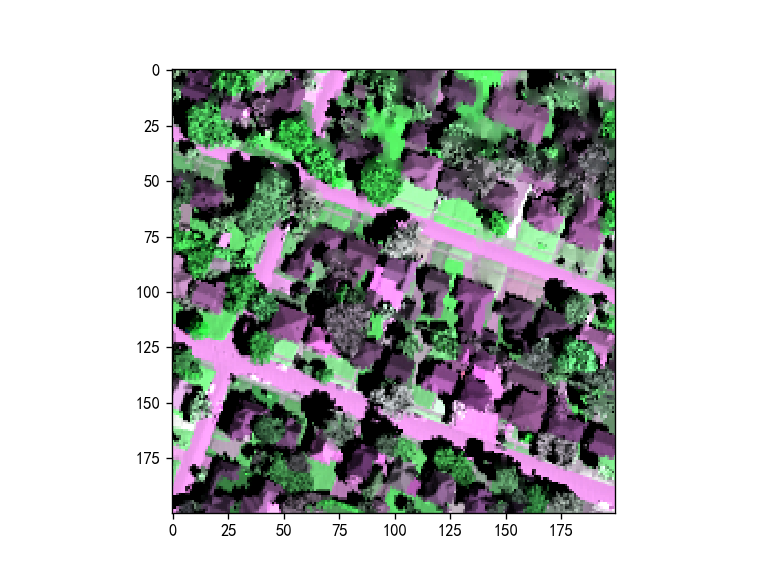

In [4]:
vis0 = ImgF.ImTransform(HSI['data'],[20, 27, 17], 1)

In [4]:
# colors = CloudF.ClTransform(LiDAR['reflectance'][:,[20, 27, 17]], [0,1,2], 0.01)

colors = LiDAR['reflectance'][:,[20, 27, 17]]
colors = colors/np.max(colors)

cloud_hsil = o3d.geometry.PointCloud()
# colors = CloudF.ClTransform(HSIcolor, [0,1,2])
cloud_hsil.points = o3d.utility.Vector3dVector(LiDAR['points'])
cloud_hsil.colors = o3d.utility.Vector3dVector(colors)


o3d.visualization.draw_geometries([cloud_hsil])

In [6]:
# savefold = "/boot/jxd/Ndata/UH_2018/figs_scene1/"
# o3d.io.write_point_cloud(savefold + "scene1_hsi_cloud_ref_gt.ply", cloud_hsil)

<IPython.core.display.Javascript object>


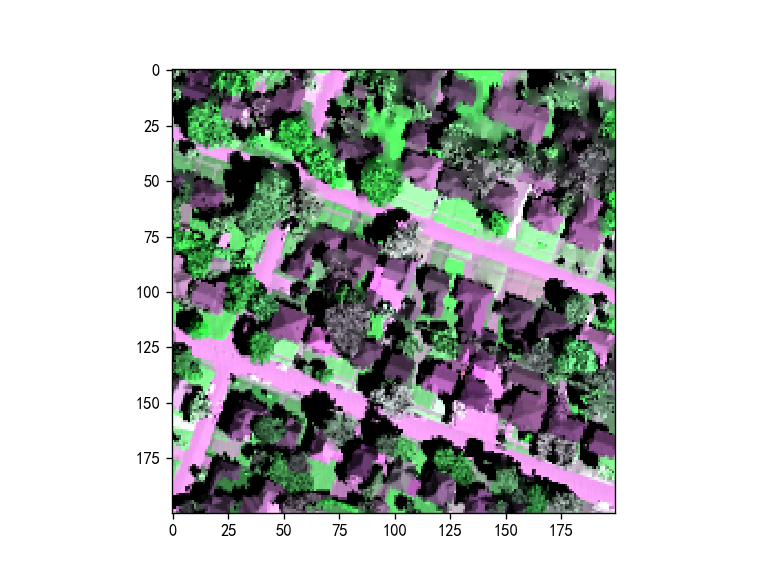

In [6]:
HSI_cube = ImgF.view_cube(HSI['data'], [20, 27, 17], 40, 1, 1, 'jet', 0.03)

In [8]:
# savefold = "/boot/jxd/Ndata/UH_2018/figs_scene1/"
# o3d.io.write_point_cloud(savefold + "scene1_hsi_cube2.ply", HSI_cube)

### main

In [5]:
Iutility = HSIL.Iutility.Img_utility()

In [6]:
Intensity = np.asarray(LiDAR['III'][:,1], np.float)
Intensity[Intensity>5000] = 5000
Intensity = Intensity/np.max(Intensity)

<IPython.core.display.Javascript object>


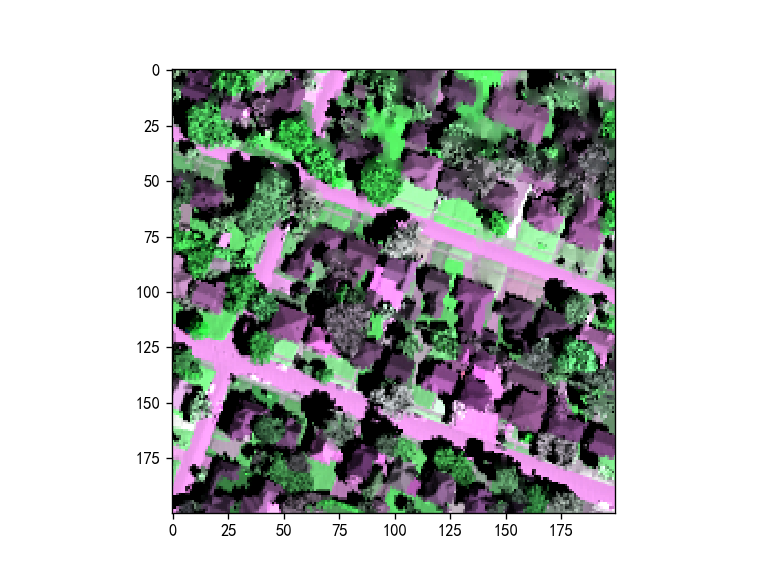

In [7]:
IHSPC = IHSPC_class.IHSPC_class()

IHSPC.setPoints(LiDAR['points'])
colorIII = np.asarray(LiDAR['III'], np.float64)[:, [0, 1, 2]]/5000
# IHSPC.setColors(colorIII)
IHSPC.setColors(colors)
IHSPC.setNumReturn(LiDAR['num_return'])
IHSPC.setHSI(HSI)
IHSPC.setIntensity(Intensity)

In [9]:
cloud_hsi_ori = IHSPC.visI() 

In [13]:
# cloud_hsi_ori_o3d = o3d.geometry.PointCloud()
# cloud_hsi_ori_o3d.points = o3d.utility.Vector3dVector(np.asarray(cloud_hsi_ori.points))
# cloud_hsi_ori_o3d.colors = o3d.utility.Vector3dVector(np.asarray(cloud_hsi_ori.colors))
# savefold = "/boot/jxd/Ndata/UH_2018/figs_scene1/"
# o3d.io.write_point_cloud(savefold + "scene_hsi_cloud_ori.ply", cloud_hsi_ori_o3d)

### DSM_N

In [8]:
IHSPC.Compute_DSM()

<IPython.core.display.Javascript object>


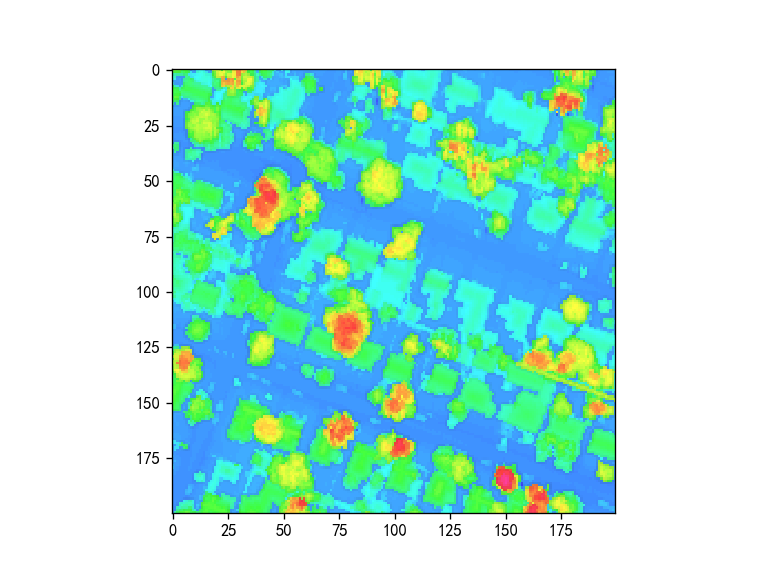

In [9]:
dsm_smooth_vis = Iutility.visualizeDEM(IHSPC.dsm, np.min(IHSPC.dsm), 0.1)
plt.figure()
plt.imshow(dsm_smooth_vis)
plt.show()

In [16]:
# plt.axis("off")
# savefold = "/boot/jxd/Ndata/UH_2018/figs_scene1/"
# plt.savefig(savefold + "scene1_DSM.pdf", dpi = 300)

<IPython.core.display.Javascript object>


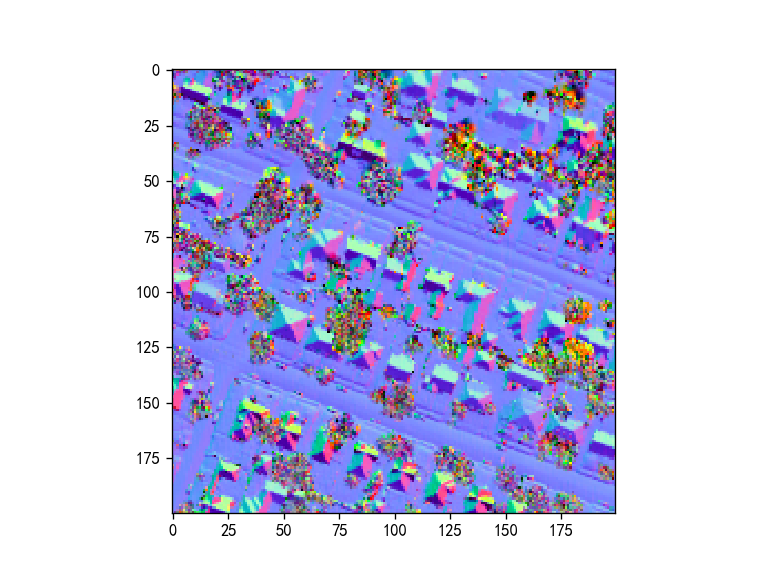

In [10]:
IHSPC.Compute_N()

In [18]:
# plt.axis("off")
# savefold = "/boot/jxd/Ndata/UH_2018/figs_scene1/"
# plt.savefig(savefold + "scene1_Normals.pdf", dpi = 300)

### intensity

In [11]:
IHSPC.Compute_Intensity()

<IPython.core.display.Javascript object>


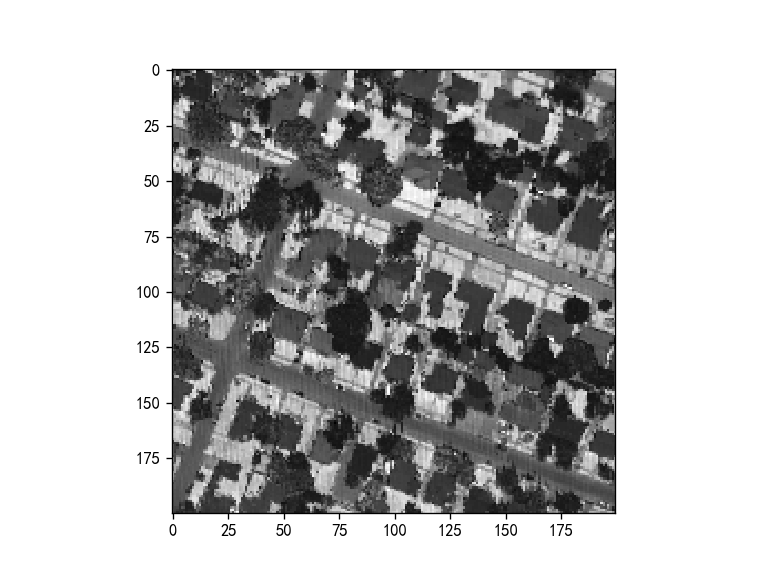

In [12]:
plt.figure()
plt.imshow(IHSPC.Img, cmap = "gray")
plt.show()

In [21]:
# plt.axis("off")
# savefold = "/boot/jxd/Ndata/UH_2018/figs_scene1/"
# plt.savefig(savefold + "scene1_Intensity.pdf", dpi = 300)

### shadow_remove

<IPython.core.display.Javascript object>


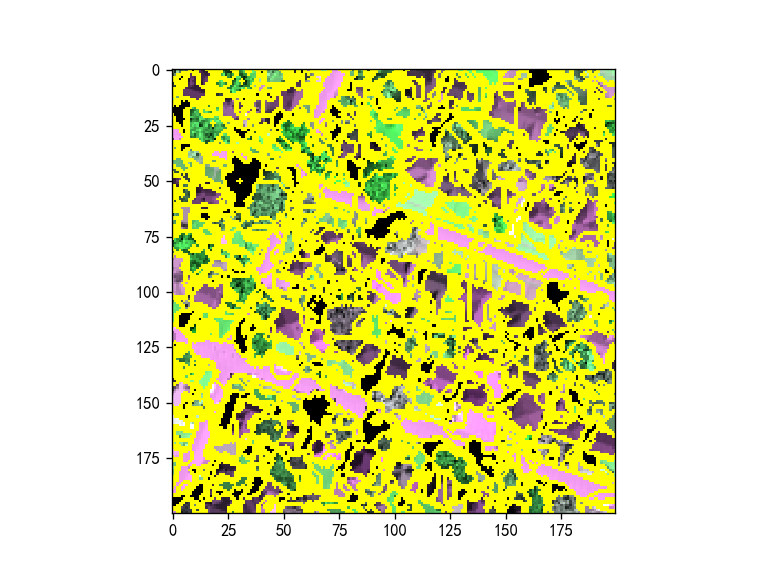

In [13]:
IHSPC.Supixel_HSI(0.06, 0.02, 1)

<IPython.core.display.Javascript object>


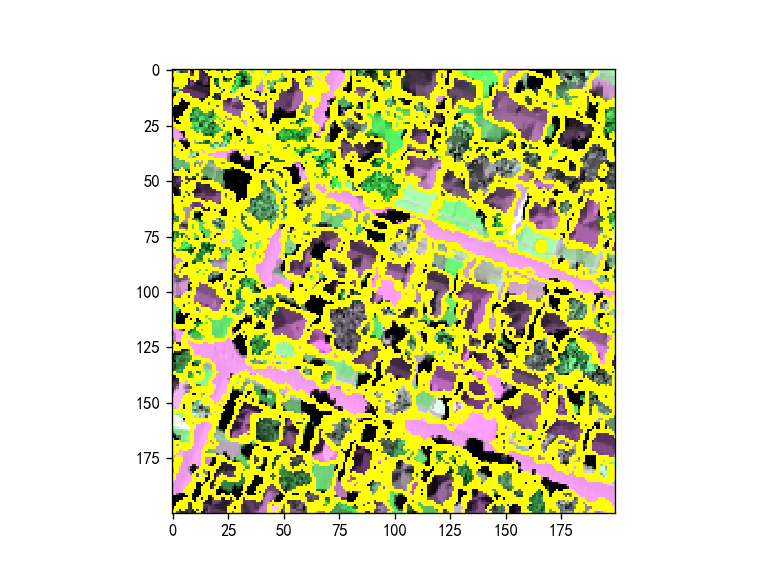

In [14]:
IHSPC.Supixel_DI(0.3, 0.3, 0.2, 5)

<IPython.core.display.Javascript object>


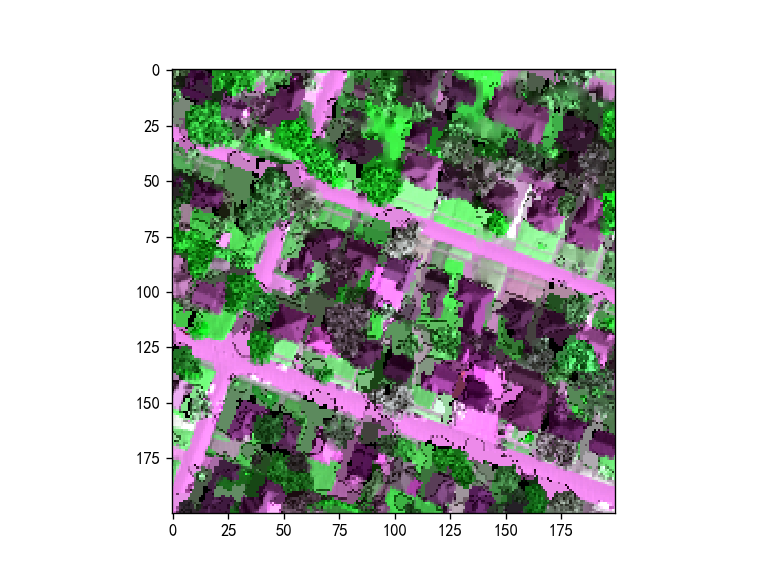

In [15]:
IHSPC.remove_shadow(0.2)

### light es

In [16]:
IHSPC.SegBuilding(1., 100, 0.15, -13.)

In [17]:
IHSPC.LightEstimate()

### cloud_seg

In [119]:
IHSPC.cloud_seg(0.04 , 30, 0.025, 200, 140, 100)

In [43]:
cloud_sup = IHSPC.vis_sup()

In [85]:
IHSPC.Ref_prepare()

In [86]:
IHSPC.solve_R(15, 0.2)

In [94]:
visR = IHSPC.visR()